In [3]:
#pip install tslearn

In [1]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from termcolor import colored
import csv
#import tslearn
#from tslearn.metrics import dtw

# Cleaned csv data

In [46]:
path = '/Users/hasan/Desktop/Anaconda/IR Project data/Cleaned Geolife csv format/'
I = glob.glob(path+'/*.csv', recursive=True)

data = []
for i in range(len(I)):
    data.append(np.array(pd.read_csv(path+str(i)+'.csv', header=None)))

data = np.array(data, dtype=object)
print(len(data))

14187

# Vectorizing trajectories

In [47]:
n_x_grids = 50
n_y_grids = 50
sigma_coeff = 3
M = len(data)
reduction_dim = 100
option = 'binary' #'multipass'
max_limit = 50

In [48]:
def getGridsXAndY(data, n_x_grids, n_y_grids, path=None):
    '''
    return: x, y-linspaces in the rectangle (x_min, y_min), (x_max, y_max)
    '''
    x_min, y_min = np.min([np.min(data[i], axis=0) for i in range(len(data))], axis=0)
    x_max, y_max = np.max([np.max(data[i], axis=0) for i in range(len(data))], axis=0)
    x_margin = 0.05 * (x_max - x_min)
    y_margin = 0.05 * (y_max - y_min)
    x = np.linspace(x_min - x_margin, x_max + x_margin, n_x_grids+1)
    y = np.linspace(y_min - y_margin, y_max + y_margin, n_y_grids+1)
    if path:
        np.savetxt(path+"x.csv", x.reshape(1, len(x)), delimiter=",")
        np.savetxt(path+"y.csv", y.reshape(1, len(y)), delimiter=",")
        np.savetxt(path+"minMaxs.csv", [x_min, y_min, x_max, y_max], delimiter="'")
    return x, y, x_min, y_min, x_max, y_max

In [49]:
path1 = '/Users/hasan/Desktop/Anaconda/IR Project data/'
x, y, x_min, y_min, x_max, y_max = getGridsXAndY(data, n_x_grids, n_y_grids, path=None)
n_x_grids = len(x) - 1
n_y_grids = len(y) - 1

In [50]:
def centersSimilarityMatrix(sigma_coeff=5, path=None):
    '''
    Gives the similarity matrix of centers of grids using Gauusian kernel
    '''
    tensor = np.zeros((n_x_grids, n_y_grids, 2))
    for i in range(n_x_grids):
        for j in range(n_y_grids):
            tensor[i][j] = [(x[i]+x[i+1])/2, (y[j]+y[j+1])/2]
    tensor = tensor.reshape(-1,2)
    simMatrix = np.ones((len(tensor), len(tensor)))
    sigma = sigma_coeff * ((y_max-y_min)+(x_max-x_min))/(n_x_grids + n_y_grids)
    for i in range(len(tensor) - 1):
        simMatrix[i][i+1:] = np.exp(-np.sum((tensor[i+1:]-tensor[i])*(tensor[i+1:]-tensor[i]), 
                                             axis=1)/sigma**2)
    for i in range(len(tensor) - 1):
        simMatrix[:,i][i+1:] = simMatrix[i][i+1:]
    if path:
        np.savetxt(path+"Similarity_Matrix.csv", simMatrix, delimiter=",")
    return simMatrix

In [51]:
C = centersSimilarityMatrix(sigma_coeff, path=None)
print(C.shape)

(2500, 2500)

In [52]:
def vectorizeLineSegment(LineSegment): 
    '''
    LineSegment: of shape (2, 2); coordinates of start and end are given; [[x1, y1], [x2, y2]]
    return: a binary vector of length n_x_grids x n_y_grids, which shows if 
            LineSegment has occured in each grid or not
    '''
    array = np.zeros((n_x_grids, n_y_grids))
    p1, p2 = LineSegment
    slope = (p2-p1)[1]/((p2-p1)[0] + 1e-10)
    i1 = np.where(x - p1[0] < 0)[0][-1]
    i2 = np.where(x - p2[0] < 0)[0][-1]
    xIdxStart = min(i1, i2)
    xIdxEnd = max(i1, i2)

    if xIdxEnd != xIdxStart:
        ''' dealing with start point of lineSegment'''
        if i1 < i2:
            j_start = np.where(y - p1[1] < 0)[0][-1]
            y_val_end = slope * (x[i1+1] - p1[0]) + p1[1]
        else:
            j_start = np.where(y - p2[1] < 0)[0][-1]
            y_val_end = slope * (x[i2+1] - p1[0]) + p1[1]
        j_end = np.where(y - y_val_end < 0)[0][-1]
        array[xIdxStart][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1

        ''' dealing with end point of lineSegment'''
        if i1 < i2:
            j_end = np.where(y - p2[1] < 0)[0][-1]
            y_val_start = slope * (x[i2] - p1[0]) + p1[1]
        else:
            j_end = np.where(y - p1[1] < 0)[0][-1]
            y_val_start = slope * (x[i1] - p1[0]) + p1[1]
        j_start = np.where(y - y_val_start < 0)[0][-1]
        array[xIdxEnd][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1

        ''' dealing with non-endpoints of lineSegment'''
        for i in range(xIdxStart+1, xIdxEnd):
            y_val_start = slope * (x[i] - p1[0]) + p1[1]
            y_val_end = slope * (x[i+1] - p1[0]) + p1[1]
            j_start = np.where(y - y_val_start < 0)[0][-1]
            j_end = np.where(y - y_val_end < 0)[0][-1]
            array[i][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1
    else:
        y_val_start = min(p1[1], p2[1])
        y_val_end = max(p1[1], p2[1])
        j_start = np.where(y - y_val_start < 0)[0][-1]
        j_end = np.where(y - y_val_end < 0)[0][-1]
        array[xIdxStart][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1
    return array.reshape(n_x_grids * n_y_grids)

In [53]:
def vectorizeTrajectory(trajectory, option): # T --> T_tilda
    '''
    trajectory: of shape (m, 2)
    return: a vector of length n_x_grids x n_y_grids, which shows the number 
            of occurences of trajectory in each grid
    '''
    A = [vectorizeLineSegment(trajectory[i:i+2]) for i in range(len(trajectory) - 1)]
    if option == 'multipass':
        return np.sum(A, axis=0)
    elif option == 'binary':
        return np.sign(np.sum(A, axis=0))


def vectorizeData(data, option): # data --> D_tilda
    ''' 
    vectorizes vectorizeTrajectory() over data 
    '''
    mappedData = [vectorizeTrajectory(data[i], option) for i in range(len(data))]
    return np.array(mappedData).T

In [54]:
start_time = time.time()
D_tilda = vectorizeData(data, option)
print(time.time() - start_time)

501.872985124588


In [55]:
import scipy 

def dimReductionData(D_tilda, option, reduction_dim, path=None):
    '''
    Performs dimentionality reduction using SVD of similarity matrix C of centers of grids
    path='/content/gdrive/My Drive/IR Project/'
    '''
    Delta, P = np.linalg.eigh(C, UPLO='L')
    I = np.where(Delta <= 1e-15)[0]
    Delta[I] = 0
    Delta_0 = Delta 
    D_tilda_tilda = np.diag(np.sqrt(Delta_0)) @ P.T @ D_tilda
    U, S, Vt = scipy.linalg.svd(D_tilda_tilda)
    U_e = U[:, :reduction_dim] 
    if path:
        np.savetxt(path+"Delta_0_sqrt@Pt_"+ option +".csv", 
                   np.diag(np.sqrt(Delta_0)) @ P.T, delimiter=',')
        np.savetxt(path+"U_e_"+ option +".csv", U_e, delimiter=',')
        np.savetxt(path+"reducedData_"+ option +".csv", U_e.T @ D_tilda_tilda, 
                   delimiter=',')
    return np.sqrt(Delta_0), P.T, U_e, U_e.T @ D_tilda_tilda

In [56]:
s = time.time()
Delta_0_sqrt, Pt, U_e, reducedData = \
                    dimReductionData(D_tilda, option, reduction_dim, path=None)

print(reducedData.shape)
print(time.time() - s)

(100, 14187)
22.85414719581604


In [57]:
def gridAggregateDistVectorized(traj_vectorized, data_vectorized, option):
    '''
    Calculates the Grid Aggregated Distance between traj_vectorized and data_vectorized 
    (which is an array of vectorized trajectories) with respect to centers matrix C; 
    normalized by the number of grids
    '''
    c = np.diag(Delta_0_sqrt) @ Pt @ (data_vectorized - traj_vectorized).T
    dists = np.sum(c * c, 0)
    return np.sqrt(dists)/(n_x_grids * n_y_grids)

In [58]:
def dimReducedQuery(query, option):
    Min_x, Min_y = np.min(query, axis=0)
    Max_x, Max_y = np.max(query, axis=0)
    if (x[0] < Min_x and y[0] < Min_y and Max_x < x[-1] and Max_y < y[-1]):
        T_q_tilda = vectorizeTrajectory(query, option=option) # vectorizedQuery
        T_q_tilda_tilda = np.diag(Delta_0_sqrt) @ Pt @ T_q_tilda
        T_q_e_tilda_tilda = U_e.T @ T_q_tilda_tilda
        return T_q_e_tilda_tilda 
    else:
        print(colored(f"The query is not in the specified range of data.\n \
        Please enter a query in the valid rectangular area: \n \
        {[x[0], x[-1]]}x{[y[0], y[-1]]}", "yellow"))
        return

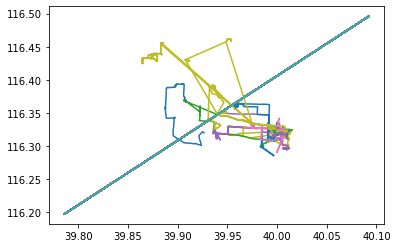

In [59]:
for i in range(100):
    plt.plot(data[i][:,0], data[i][:,1])
    plt.plot(x, y)
plt.show()

In [60]:
def queryRankList(query, reduction_dim, reducedData, option, max_limit, k=None, r=None): 
    '''
    returns a list; the indices of the trajectories to be retrieved for the query
    '''
    mappedReducedQuery = dimReducedQuery(query, option=option)
    distQueryFromReducedData = LA.norm(reducedData - mappedReducedQuery.reshape(reduction_dim, 1), 
                                       axis=0) / (n_x_grids * n_y_grids)
    distQueryFromReducedDataSortedIndices = np.argsort(distQueryFromReducedData)
    if k:
        return distQueryFromReducedDataSortedIndices[:k]
    elif r:
        idx = np.where(distQueryFromReducedData < r)[0]
        return idx[:max_limit]
    else:
        print(colored("Please specify k or r", "yellow"))
        return

In [61]:
def dataRankedLists(data_vectorized, reducedData, option, path=None): 
    # get real dists of data points with grid aggregated distance
    n = len(data_vectorized)
    distsData = np.zeros((n, n))
    for j in range(n-1):
        distsData[j][j+1:] = gridAggregateDistVectorized(data_vectorized[j], 
                                                         data_vectorized[j+1:], 
                                                         option=option)
    distsData = distsData + distsData.T
    distsDataArgSorts = np.argsort(distsData)
    if path:
        np.savetxt(path+"distsData_"+option+".csv", distsData, delimiter=",")
        np.savetxt(path+"distsDataArgSorts_"+option+".csv", distsDataArgSorts, delimiter=",")

    # get dists of data points after dim reduction
    distsReducedData = np.zeros((n,n))
    for j in range(n-1):
        a = LA.norm(reducedData[j] - reducedData[j+1:], axis=1)/(n_x_grids * n_y_grids)
        distsReducedData[j][j+1:] = a
    distsReducedData = distsReducedData + distsReducedData.T
    distsReducedDataArgSorts = np.argsort(distsReducedData)
    if path:
        np.savetxt(path+"distsReducedData_"+option+".csv", distsReducedData, delimiter=",")
        np.savetxt(path+"distsReducedDataArgSorts_"+option+".csv", distsReducedDataArgSorts, 
                   delimiter=",")
    return distsData, distsDataArgSorts, distsReducedData, distsReducedDataArgSorts


In [62]:
np.random.seed(10)
I = np.random.permutation(len(data))[:1000]
data_sample = data[I]

In [63]:
print(I)

array([ 9285,  8078,  7828, 12242, 12515,  9558,  1479, 12238,  4376,
        4773,  9067,  8739,  2310,  9294, 12926,  3876,  9345,  7032,
        4526,  5816,  1633, 12647,   484, 12462, 12071, 13367,  8661,
        2470,  1148,  6821,  4911,  7907, 10700,   237,  4594, 14054,
       10458,   979, 10774, 13890, 11851, 10464,  5664,  8966, 10032,
        5725, 12639,  9061,  3654,  6229, 12946,  4202,  1372, 10270,
       11071,   374,  9365, 11477,  6351, 11955,  8648,  4294,  9849,
        1911,  8351, 12325, 13867,  2178,  8377,  8938,  1091,  2647,
       13262,  9390,  4791,   190, 14106,  9457,  1887,  9598,  3603,
       11980, 11443,   976,  4612, 11039,  3732,  8222, 12980,  7523,
        7077,  2903,  4183,  7431,  1465,  1707,  3673, 10945, 10097,
        5737, 14123,  7945,  1600, 10865, 11909, 11671,  8674,   145,
        4577,  1573,  9999,  9017,  9872,  1144, 11360,  6895,  8095,
        5830, 12054,  4701,   937, 13312, 10339,  4338,  1236, 10149,
       13242,   117,

In [64]:
start_time = time.time()
distsData, distsDataArgSorts, distsReducedData, distsReducedDataArgSorts = \
                                dataRankedLists(D_tilda.T[I], reducedData.T[I], 
                                                option, path=None) #path1
print(time.time() - start_time)

288.46980476379395


In [70]:
def precisionAndRecallData(data, N, max_limit, distsData, distsDataArgSorts, 
                           distsReducedData, distsReducedDataArgSorts, k=None, r=None): 
    '''
    calculates percision and recall for all data points as well as 
    the average of percision and recall for all data @N (Note: This is not AP)
    path='/content/gdrive/My Drive/IR Project/'
    This function is not sensitive to k if k>=N.
    Note: Don't give values for both k and r (one of them should be None).
    '''
    percision = np.zeros(len(data))
    recall = np.zeros(len(data))
    if (k and r):
        for j in range(len(data)):
            c = 0
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j][:N]:
                    c += 1
            percision[j] = c/N
            recall[j] = c/N
        percision_k = percision.copy()
        recall_k = recall.copy()
        for j in range(len(data)):
            d = 0
            idx = np.where(distsData[j] < r)[0][:min(max_limit, N)]
            idx_red = np.where(distsReducedData[j] < r)[0][:min(max_limit, N)]
            for i in range(len(idx_red)):
                if idx_red[i] in idx:
                    d += 1
            percision[j] = d/len(idx_red)
            recall[j] = d/len(idx)
        return {f"k={k}:": [percision_k, recall_k, np.mean(percision_k), np.mean(recall_k)],
                f"r={r}:": [percision, recall, np.mean(percision), np.mean(recall)]}
    elif k:
        for j in range(len(data)):
            c = 0
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j][:N]:
                    c += 1
            percision[j] = c/N
            recall[j] = c/N
        return percision, recall, np.mean(percision), np.mean(recall)
    elif r:
        for j in range(len(data)):
            c = 0
            idx = np.where(distsData[j] < r)[0]
            idx_red = np.where(distsReducedData[j] < r)[0]
            I = np.argsort(distsData[j][idx])
            idx = idx[I][:min(max_limit, N)]
            J = np.argsort(distsReducedData[j][idx_red])
            idx_red = idx_red[J][:min(max_limit, N)]
            for i in range(len(idx_red)):
                if idx_red[i] in idx:
                    c += 1
            percision[j] = c/len(idx_red)
            recall[j] = c/len(idx)
        return percision, recall, np.mean(percision), np.mean(recall)
    else:
        print(colored("Pleas specify the value of k or r.", "yellow"))

### Average of percisions of all data points where each is used as kNN queries

In [71]:
# Note: for kNN queries percision and recall are the same
percision = []
recall = []
mean_percision = []
mean_recall = []
print('option:', option)

for k in [5,10,20]:
    a, b, c, d = precisionAndRecallData(data_sample, N=k, max_limit=max_limit, 
                                        distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                                        distsReducedData=distsReducedData, 
                                        distsReducedDataArgSorts=distsReducedDataArgSorts, 
                                        k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.8676  0.8921  0.90735]
mean_recall: [0.8676  0.8921  0.90735]


In [34]:
# Note: for kNN queries percision and recall are the same
percision = []
recall = []
mean_percision = []
mean_recall = []
print('option:', option)

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data_sample, N=k, max_limit=max_limit, 
                                        distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                                        distsReducedData=distsReducedData, 
                                        distsReducedDataArgSorts=distsReducedDataArgSorts, 
                                        k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [0.948   0.959   0.96525]
mean_recall: [0.948   0.959   0.96525]


### Averages of percisions and recalls of all data points where each is used as range queries

In [35]:
np.max(distsData), np.max(distsReducedData)

(6.406667235189689, 6.404558060858125)

In [72]:
percision = []
recall = []
mean_percision = []
mean_recall = []
print('option:', option)

for r in [0.001, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data_sample, N=10, max_limit=max_limit,  
                                        distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                                        distsReducedData=distsReducedData, 
                                        distsReducedDataArgSorts=distsReducedDataArgSorts, 
                                        k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.92746468 0.88955595 0.8883381 ]
mean_recall: [0.9549 0.9023 0.8892]


In [36]:
percision = []
recall = []
mean_percision = []
mean_recall = []
print('option:', option)

for r in [0.001, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data_sample, N=10, max_limit=max_limit, 
                                        distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                                        distsReducedData=distsReducedData, 
                                        distsReducedDataArgSorts=distsReducedDataArgSorts, 
                                        k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [0.999      0.98944841 0.97646944]
mean_recall: [1.     1.     0.9978]


In [73]:
def precisionAndRecallDataPoint(index, N, max_limit, distsData, distsDataArgSorts, 
                                distsReducedData, distsReducedDataArgSorts, k=None, r=None): 
    '''
    calculates percision and recall for one data point (as a query) @ N
    index: the index of data point
    path='/content/gdrive/My Drive/IR Project/'
    This function is not sensitive to k if k >= N
    '''
    if k:
        c = 0
        for i in range(N):
            if distsReducedDataArgSorts[index][i] in distsDataArgSorts[index][:N]:
                c += 1
        percision = c/N
        recall = c/N
        return percision, recall
    elif r:
        c = 0
        idx = np.where(distsData[index] < r)[0]
        idx_red = np.where(distsReducedData[index] < r)[0]
        I = np.argsort(distsData[index][idx])
        idx = idx[I][:min(max_limit, N)]
        J = np.argsort(distsReducedData[index][idx_red])
        idx_red = idx_red[J][:min(max_limit, N)]
        for i in range(len(idx_red)):
            if idx_red[i] in idx:
                c += 1
        percision = c/len(idx_red)
        recall = c/len(idx)
        return percision, recall
    else:
        print(colored("Pleas specify the value of k or r.", "yellow"))


In [74]:
def averagePrecisionData(data, path, max_limit, reduction_dim, reducedData, 
                         option, k=None, r=None):
    '''
    calculates average percision (AP) for all data points as well as 
    the average of AP on all data points as queries (i.e. MAP)
    path='/content/gdrive/My Drive/IR Project/'
    Note: Don't give values for both k and r (one of them should be None).
    '''
    distsData = np.array(pd.read_csv(path+"distsData_"+option+".csv", header=None))
    distsDataArgSorts = np.array(pd.read_csv(path+"distsDataArgSorts_"+option+".csv", header=None))
    distsReducedData = np.array(pd.read_csv(path+"distsReducedData_"+option+".csv", header=None))
    distsReducedDataArgSorts = np.array(pd.read_csv(path+"distsReducedDataArgSorts_"+option+".csv", header=None))
    n = len(data)
    AP = np.zeros(n)
    if k:
        AP_temp = np.zeros((k, n))
        for i in range(k):
            percision, _, _, _ = precisionAndRecallData(data, i+1, max_limit, 
                                        distsData, distsDataArgSorts, distsReducedData, 
                                        distsReducedDataArgSorts, k=k, r=r)
            for t in range(n):
                if distsReducedDataArgSorts[t][i] in distsDataArgSorts[t]:
                    AP_temp[i][t] = percision[t] 

        AP = np.mean(AP_temp, 0)
        MAP = np.mean(AP)
        return AP, MAP
    elif r:
        for t in range(n):
            AP_temp = []
            s = len(np.where(distsReducedData[t] < r)[0])
            for i in range(s):
                percision, _ = precisionAndRecallDataPoint(t, i+1, max_limit, 
                                        distsData, distsDataArgSorts, distsReducedData, 
                                        distsReducedDataArgSorts,k=None, r=r)
                idx = np.where(distsData[t] < r)[0]
                idx_red = np.where(distsReducedData[t] < r)[0]
                I = np.argsort(distsData[t][idx])
                idx = idx[I][:min(max_limit, i+1)]
                J = np.argsort(distsReducedData[t][idx_red])
                idx_red = idx_red[J][:min(max_limit, i+1)]
                if i < len(idx_red):
                    if idx_red[i] in idx:
                        AP_temp.append(percision)
            AP[t] = np.sum(AP_temp)/s
        MAP = np.mean(AP)
        return AP, MAP

### AP and MAP for kNN queries

In [75]:
start_time = time.time()
AP = []
MAP = []
print('option:', option)
for k in [5, 10, 20]:
    a, b = averagePrecisionData(data_sample, path1, max_limit, reduction_dim, 
                                reducedData.T[I].T, option, k=k, r=None)
    AP.append(a)
    MAP.append(b)

print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: binary
MAP: [0.86317    0.87506683 0.89043278]
Total time: 3.7365458011627197


In [39]:
start_time = time.time()
AP = []
MAP = []
print('option:', option)
for k in [5, 10, 20]:
    a, b = averagePrecisionData(data_sample, path1, max_limit, reduction_dim, 
                                reducedData.T[I].T, option, k=k, r=None)
    AP.append(a)
    MAP.append(b)

print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: multipass
MAP: [0.95966667 0.95770198 0.96035579]
Total time: 4.227134943008423


### AP and MAP for range queries

In [85]:
start_time = time.time()
AP = []
MAP = []
print('option:', option)

for r in [0.001, 0.005, 0.01]:
    s_time = time.time()
    a, b = averagePrecisionData(data_sample, path1, max_limit, reduction_dim, 
                                reducedData.T[I].T, option, k=None, r=r)
    AP.append(a)
    MAP.append(b)
    print(time.time() - s_time)
    
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: binary
4.198775053024292
167.11280465126038
362.10226011276245
MAP: [0.81156418 0.20245203 0.03756224]
533.4157500267029


In [40]:
start_time = time.time()
AP = []
MAP = []
print('option:', option)

for r in [0.001, 0.005, 0.01]:
    a, b = averagePrecisionData(data_sample, path1, max_limit, reduction_dim, 
                                reducedData.T[I].T, option, k=None, r=r)
    AP.append(a)
    MAP.append(b)
    
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: multipass
MAP: [0.999      0.98734919 0.95820147]
3.397214889526367


In [77]:
def nDCG(data, path, max_limit, reduction_dim, option, N, k=None, r=None):
    '''
    calculates average nDCG @N for all data points as well as 
    the average of nDCG @N on all data points as queries;
    N should be <= k;
    path='/content/gdrive/My Drive/IR Project/'
    Note: Don't give values for both k and r (one of them should be None).
    '''
    distsData = np.array(pd.read_csv(path+"distsData_"+option+".csv", header=None))
    distsDataArgSorts = np.array(pd.read_csv(path+"distsDataArgSorts_"+option+".csv", header=None)).tolist()
    distsReducedData = np.array(pd.read_csv(path+"distsReducedData_"+option+".csv", header=None))
    distsReducedDataArgSorts = np.array(pd.read_csv(path+"distsReducedDataArgSorts_"+option+".csv", header=None))
    DCG = np.zeros(len(data))
    if k: 
        iDCG = np.sum([(k-i)/math.log(i+2, 2) for i in range(k)])
        for j in range(len(data)):
            rel = np.zeros(N)
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j]:
                    if k - distsDataArgSorts[j].index(distsReducedDataArgSorts[j][i]) > 0:
                        rel[i] = k - distsDataArgSorts[j].index(distsReducedDataArgSorts[j][i])
            DCG[j] = np.sum([rel[i]/math.log(i+2, 2) for i in range(N)])
        return DCG/iDCG, np.mean(DCG/iDCG)
    elif r:
        for j in range(len(data)):
            I = np.where(distsData[j] < r)[0]
            relevant = distsDataArgSorts[j][:len(I)]
            J = np.where(distsReducedData[j] < r)[0]
            retrieved = distsReducedDataArgSorts[j][:len(J)]
            relevance = list(reversed(range(1, N+1)))
            iDCG = np.sum([relevance[i]/math.log(i+2, 2) for i in range(N)])
            rel = np.zeros(N)
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j][:len(I)]:
                    if N - distsDataArgSorts[j].index(distsReducedDataArgSorts[j][i]) > 0:
                        rel[i] = N - distsDataArgSorts[j].index(distsReducedDataArgSorts[j][i])
            DCG[j] = np.sum([rel[i]/math.log(i+2, 2) for i in range(N)])
        return DCG/iDCG, np.mean(DCG/iDCG)

In [78]:
# N <= k
print('option:', option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=5, 
                      k=k, r=None)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=10, 
                      k=k, r=None)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs@5: [0.91817087 0.78217436 0.5823225 ]
nDCGs@10: [0.94426914 0.9393703  0.79893225]


In [42]:
# N <= k
print('option:', option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=5, 
                      k=k, r=None)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=10, 
                      k=k, r=None)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs@5: [0.98217857 0.82328761 0.602873  ]
nDCGs@10: [0.99300194 0.9885653  0.83295832]


In [79]:
print('option:', option)
nDCGs = []
for r in [0.001, 0.005, 0.01]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=5, 
                      k=None, r=r)[1])
print(colored(f'nDCG@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.001, 0.005, 0.01]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=10, 
                      k=None, r=r)[1])
print(colored(f'nDCG@10: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCG@5: [0.72604454 0.88933002 0.91817087]
nDCG@10: [0.65587901 0.8951388  0.9390234 ]


In [45]:
print('option:', option)
nDCGs = []
for r in [0.001, 0.005, 0.01]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=5, 
                      k=None, r=r)[1])
print(colored(f'nDCG@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.001, 0.005, 0.01]:
    nDCGs.append(nDCG(data_sample, path1, max_limit, reduction_dim, option, N=10, 
                      k=None, r=r)[1])
print(colored(f'nDCG@10: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCG@5: [0.49055102 0.52913039 0.57346069]
nDCG@10: [0.33669295 0.37478629 0.42755948]
